# Policy Gradient Gridworld Experiments

In the following notebook we present implementations for *vanilla* and *natural policy gradient* algorithms assuming either *first order orcale access* to the gradients or *stochastic estimation with Monte-Carlo sampling*. 

Policy gradient algorithms generally work by iterating the following assignment operation:
$$
\theta_{t+1} \rightarrow \theta_{t}  + \eta g_t,
$$
where:
|  | Vanilla PG | Natural PG |
|---|---|---|
| Oracle | $g_t = \nabla_\theta J(\theta_t) $ | $g_t = \mathcal{F}_{\theta_t}^{\dagger}\nabla_\theta J(\theta_t) $ |
| Monte-Carlo | $g_t \approx \nabla_\theta J(\theta_t) $ | $g_t \approx \mathcal{F}_{\theta_t}^{\dagger}\nabla_\theta J(\theta_t) $ |

In this work we will always assume (at least for now) that the policy is parametrized by a direct-softmax:
$$
\pi(s,a) = \frac{\exp \theta(s,a)}{\sum_{a'\in A} \exp \theta(s,a')},
$$
the quantity that we optimize on (*the return*) is given by:
$$
J(\theta) = (1-\gamma) \mathbb{E}_{s \sim \theta}\Big[ \sum_{t=0}^{+\infty} \gamma^t r(s_t,a_t) \Big].
$$
For now we only care about the unregularized case.
- [ ] TODO : introduce regularization 
- [ ] TODO : introduce sampling
- [ ] TODO : introduce FIM sampling

### Important Note

This is a sketch implementation notebook used for debugging and experimenting with the algorithms, a cleaner implementation can be found in the `policy_gradients.py` script.

### Includes and initialization

In [117]:
""" Includes """
import jax
from jax import numpy as jnp
from jax.numpy import linalg as jla
import matplotlib.pyplot as plt
from env.mdp import MarkovDecisionProcess,Sampler
from env.gridworld import Gridworld, gridplot
from itertools import accumulate
from einops import rearrange, repeat
from tqdm import tqdm

from algs.policy_gradients import softmax_pi, flatten

""" Initialize the Jax RNG """
key = jax.random.PRNGKey(0) 
from jax.config import config; config.update("jax_enable_x64", True)

#### Instanciating a Gridworld environment

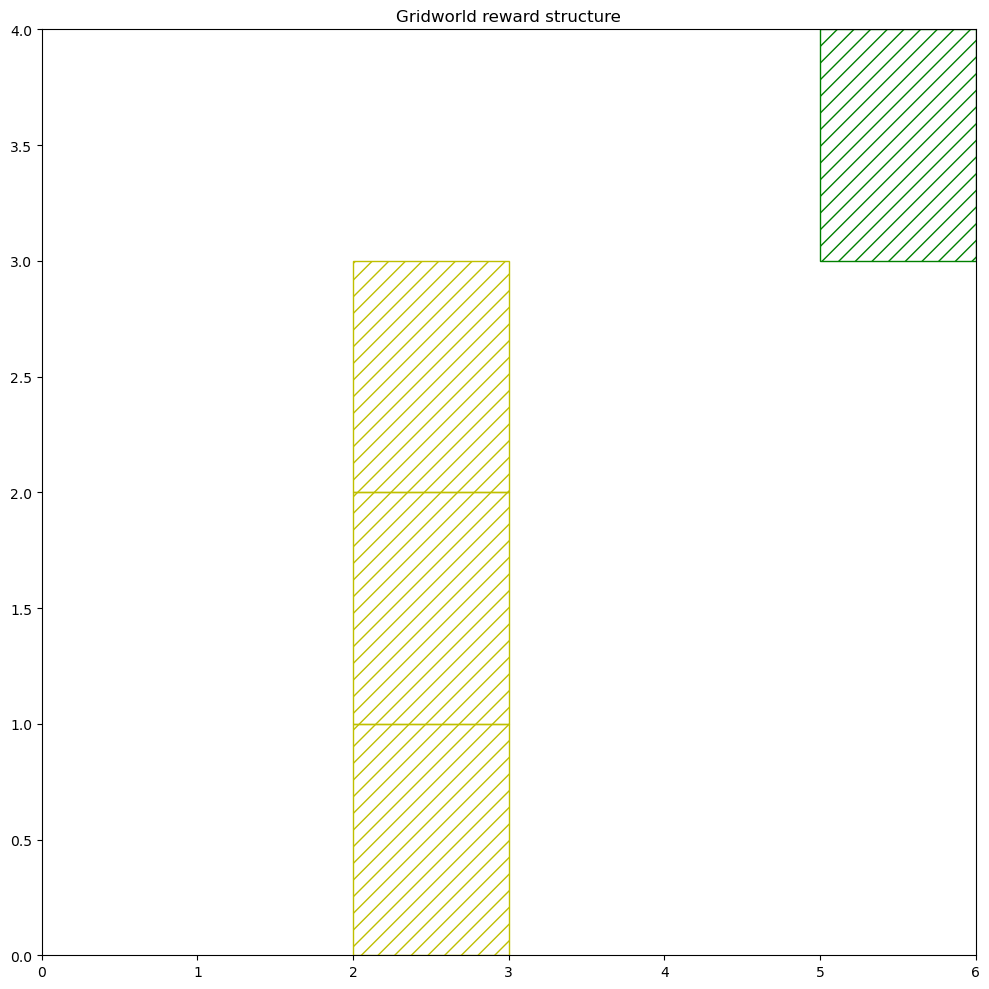

In [94]:
goals = [((5,3),100),
         ((2,0),-50),
         ((2,1),-50),
         ((2,2),-50),]
gridMDP = Gridworld(6,4,0.1,0.9,goals=goals,obstacles=[]) 
gridMDP.init_distrib =  jnp.exp(jax.random.uniform(key,(gridMDP.n,))) / \
    jnp.sum(jnp.exp(jax.random.uniform(key,(gridMDP.n,))))
    
    
fig, ax = plt.subplots(1,figsize=(10,10))
gridplot(gridMDP,ax,goals=goals)
ax.set_title('Gridworld reward structure')
fig.tight_layout()
plt.show()

#### Instanciating a policy parametrization

In [95]:
theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m))
def softmax_pi(theta):
    return jnp.exp(theta)/jnp.repeat(jnp.expand_dims(jnp.sum(jnp.exp(theta),1),1),4,1)
pi_theta = softmax_pi(theta)

### Policy Gradient using First order oracles

#### Computing the quantity $\nabla J(\theta)$

In [96]:
def closed_loop_kernel(mdp,pi):
    return jnp.einsum('sap,sa->sp',mdp.P_sa,pi) # closed loop transition kernel
def state_occ_measure(mdp,P_pi):
    return (1-mdp.gamma)*(jla.inv((jnp.eye(mdp.n)-mdp.gamma*P_pi)).transpose()@mdp.init_distrib)
def occ_measure(mdp,pi):
    mu_s = state_occ_measure(mdp,closed_loop_kernel(mdp,pi))
    return pi * repeat(mu_s, 's -> s new_axis', new_axis=mdp.m)
def J_unregularized(mdp,theta):
    return jnp.dot(flatten(mdp.R),flatten(occ_measure(gridMDP,softmax_pi(theta))))
policyGrad = jax.grad(lambda p : J_unregularized(gridMDP,softmax_pi(p)))

#### A generic policy gradient implementation

In [97]:
def PolicyGradient(_g,mdp,eta=20, nb_steps = 40):
    def logger(theta):
        return {
            'pi': softmax_pi(theta),
            'J': J_unregularized(mdp, theta)
        }
    theta = jax.random.uniform(key,(mdp.n,mdp.m))
    log = [logger(theta)]
    for step in range(nb_steps):
        theta += eta * _g(theta)
        log += [logger(theta)]
    return log, theta
log, theta = PolicyGradient(policyGrad,gridMDP)

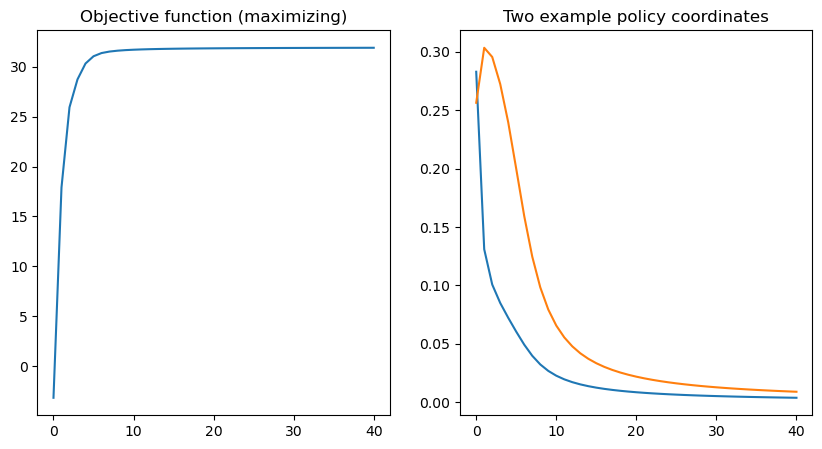

In [98]:
pis=jnp.stack([e['pi'] for e in log])
js=jnp.stack([e['J'] for e in log])
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(js)
ax[0].set_title('Objective function (maximizing)')
ax[1].plot(pis[:,0,:2])
ax[1].set_title('Two example policy coordinates')
plt.show()

#### Computing the Fisher Information Matrix

Recall that the Fisher Information Matrix (FIM) is given by:
$$
\mathcal{F}_\theta = \mathbb{E}_{s,a \sim \theta} \Big[ (\nabla_\theta \log \pi_\theta(a|s)) (\nabla_\theta \log \pi_\theta(a|s))^\top \Big]
$$

Given exact knowledge of the MDP we can compute it as follows:
1. we let `jac` denote the Jacobian of $\log \pi$ w.r.t $\theta$:
$$
\text{jac} = 
\begin{bmatrix}
\frac{\partial \log \pi(a_1|s_1)  }{\partial \theta(s_1,a_1)  }
& ... & \frac{\partial \log \pi(a_1|s_1)  }{\partial \theta(s_n,a_m)  } \\
\vdots & \ddots & \vdots \\
\frac{\partial \log \pi(a_m|s_n)  }{\partial \theta(s_1,a_1)  }
& ... & \frac{\partial \log \pi(a_m|s_n)  }{\partial \theta(s_n,a_m)  }
\end{bmatrix}
\in \mathbb{R}^{nm\times nm}
$$
2. We then batch-compute the outer product $(\nabla_\theta \log \pi_\theta(a|s)) (\nabla_\theta \log \pi_\theta(a|s))^\top$ for each $(s,a)$ pair (which we store in the `bop` tensor)
$$
\text{bop} = 
\begin{bmatrix}
    (\nabla_\theta \log \pi_\theta(a_1|s_1)) (\nabla_\theta \log \pi_\theta(a_1|s_1))^\top\\
    \vdots \\
    (\nabla_\theta \log \pi_\theta(a_m|s_n)) (\nabla_\theta \log \pi_\theta(a_m|s_n))^\top
\end{bmatrix}
\in \mathbb{R}^{nm\times nm\times nm}
$$
3. Finally we compute the FIM by taking the sum weighted by the occupancy measure:
$$
\mathcal{F}_\theta = \sum_{(s,a) \in S \times A}\mu_\theta(a,s) \cdot (\nabla_\theta \log \pi_\theta(a|s)) (\nabla_\theta \log \pi_\theta(a|s))^\top\\
$$


In [99]:
def exact_fim(theta,mdp):
    v = jax.jacfwd(lambda p : flatten(jnp.log(softmax_pi(p))))(theta) # computing the jacobian (step 1)
    jac = jnp.reshape(v,(mdp.n*mdp.m,mdp.n*mdp.m)) # flatten last two dimensions (step 1)
    bop = jnp.einsum('bi,bj->bji',jac,jac) # batch outer-product (step 2)
    return jnp.einsum('bij,b->ij',bop,flatten(occ_measure(mdp,softmax_pi(theta)))) # fisher information matrix (I hope) (step 3)

And then the natural gradient step is simply given by preconditionning the gradients with the Moore-Penrose Inverse of the exact fisher information matrix:
$$
g_t = \mathcal{F}_{\theta_t}^{\dagger}\nabla_\theta J(\theta_t) 
$$

In [100]:
def natural_gradients(theta,mdp):
    _shape = theta.shape
    g = jax.grad(lambda p : J_unregularized(gridMDP,softmax_pi(p)))(theta)    
    f_inv = jla.pinv(exact_fim(theta,mdp))
    return jnp.reshape(f_inv@flatten(g),_shape)

#### Natural PG methods

Here we compare convergence with the vanilla and the NPG approach

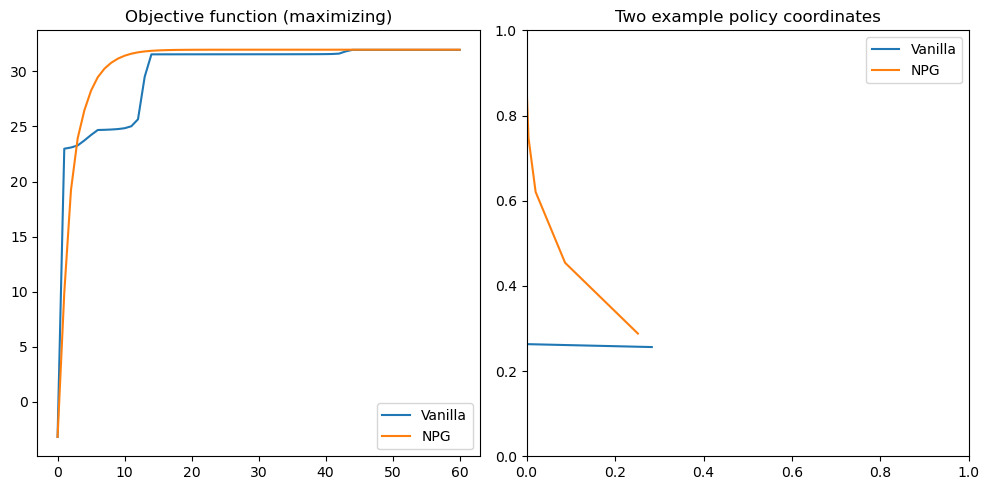

In [103]:
log_vpg, t_v = PolicyGradient(policyGrad,gridMDP,eta=2e2,nb_steps=60)
log_npg, t_n = PolicyGradient(lambda t:natural_gradients(t,gridMDP),gridMDP,eta=1e-1,nb_steps=60)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title('Objective function (maximizing)');ax[1].set_title('Two example policy coordinates')

pis=jnp.stack([e['pi'] for e in log_vpg])
js=jnp.stack([e['J'] for e in log_vpg])
ax[0].plot(js); ax[1].plot(pis[:,0,0],pis[:,0,1])
pis=jnp.stack([e['pi'] for e in log_npg])
js=jnp.stack([e['J'] for e in log_npg])
ax[0].plot(js); ax[1].plot(pis[:,1,0],pis[:,1,1])
ax[1].set_xlim([0,1]);ax[1].set_ylim([0,1])
ax[0].legend(['Vanilla','NPG'])
ax[1].legend(['Vanilla','NPG'])
fig.tight_layout()
plt.show()

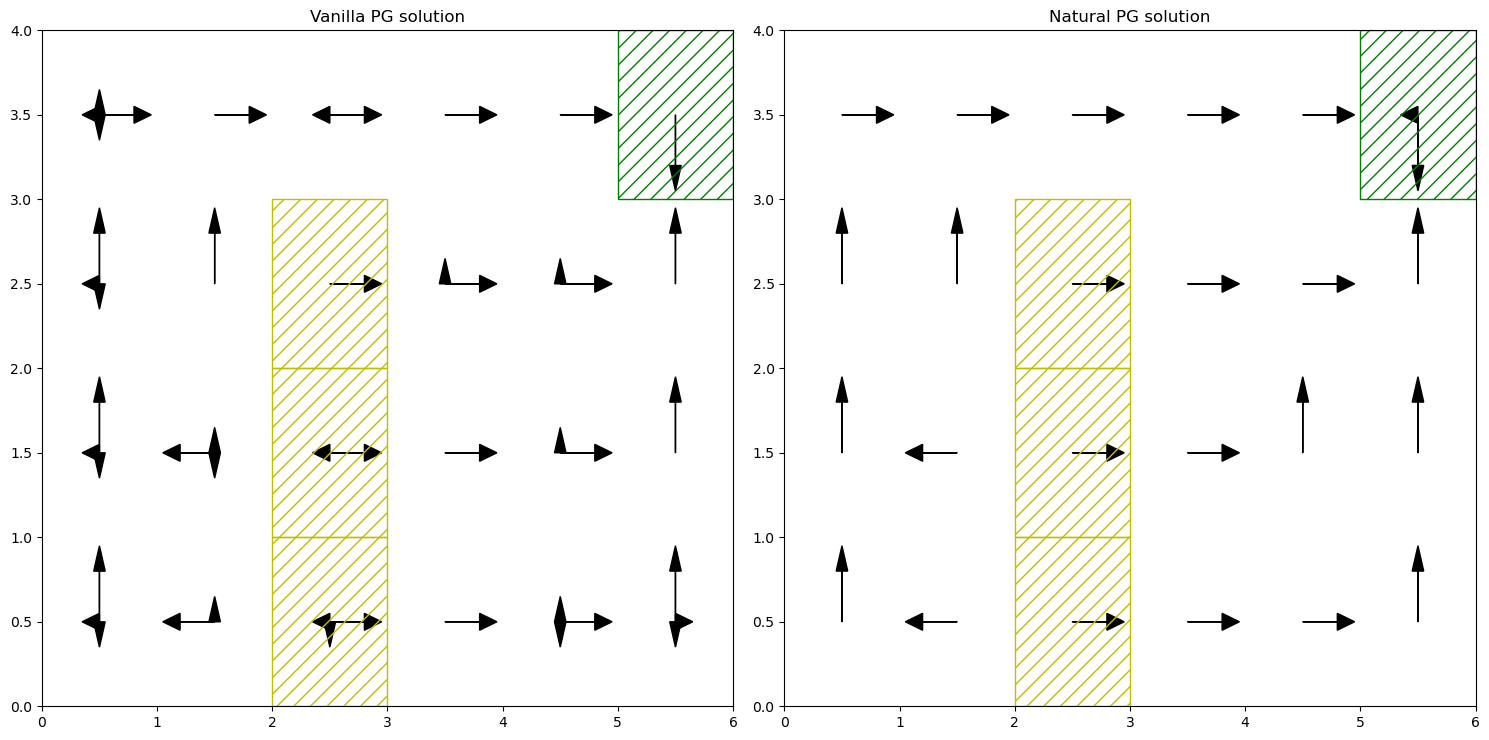

In [104]:
fig, ax = plt.subplots(1,2,figsize=(1.5*10,1.5*5))
gridplot(gridMDP,ax[0],stochastic_policy=softmax_pi(t_v),goals=goals)
ax[0].set_title('Vanilla PG solution')
gridplot(gridMDP,ax[1],stochastic_policy=softmax_pi(t_n),goals=goals)
ax[1].set_title('Natural PG solution')
fig.tight_layout()

### Policy Gradient using Monte-Carlo methods

Now the trick is that rather than directly computing the gradients using our full knowledge of the MDP we will estimate it with Monte-Carlo methods. To do so we will first collect a dataset generated by the current policy and then we will run a gradient estimator such as *GPOMDP*.

### Implementing a Sampling Routine

We sample batches of trajectories of the following form:
$$
\mathcal{B} = 
\Bigg\{
    \Bigg\{ 
        \big(
            s_t^b,   
            a_t^b,
            r_t^b    
        \big)
    \Bigg\}_{h=0}^H
\Bigg\}_{b=0}^B,
$$
each batch contains $B$ trajectories of horizon $H$.

In [108]:
smp = Sampler(gridMDP)
pi = softmax_pi(theta)

def sample_trajectory(pi,mdp,smp,H):
    def pick_action(pi,s,mdp):
        p = pi[s]; p /= jnp.sum(p)
        return jax.random.choice(key,jnp.arange(mdp.m), p = p)
        
    traj = []
    r_t = 0
    s_t = smp.reset()
    for _ in range(H):
        a_t = pick_action(pi,s_t,mdp)
        traj += [(s_t,a_t,r_t)]
        s_t, r_t = smp.step(a_t)
    return traj

def sample_batch(pi,mdp,smp,H,B):
    return [sample_trajectory(pi,mdp,smp,H) for _ in range(B)]

HORIZON = 10
BATCH = 10

batch = sample_batch(pi,gridMDP,smp,HORIZON,BATCH)

#### Estimating Policy Gradients from the Batches

We implement the `GPOMDP` estimator which has the following form:
$$
g_\theta = 
\frac{1}{B} \sum^B_{i=1} \sum^{H-1}_{h=0}
\Big( \sum^{h}_{j=0} \nabla_\theta \log \pi_\theta(a_j^i|s_j^i) \cdot r_h^i \Big)
\approx \nabla_\theta J(\theta)
$$

In [113]:
def gpomdp(batch,theta,B,H,gamma):
    def g_log(theta,s,a):
        return jax.grad(lambda p : jnp.log(softmax_pi(p))[s,a])(theta)
    def trace_grad(batch,theta,b,h):
        return jnp.sum(jnp.array([g_log(theta,e[0],e[1]) for e in batch[b][:h]]),axis=0)
    def single_sample_gpomdp(batch,theta,b,H):
        return jnp.sum(jnp.array([(gamma**h)*batch[b][h][2] \
                    *trace_grad(batch,theta,b,h) for h in range(1,H)]),axis=0)
        
    return (1/B)*jnp.sum(jnp.array([single_sample_gpomdp(batch,theta,b,H) for b in range(B)]),axis=0)

gpomdp(batch,theta,BATCH-1,HORIZON,gridMDP.gamma)

DeviceArray([[-0.01619953, -0.03841384,  0.09295849, -0.03834512],
             [ 0.        ,  0.        ,  0.        ,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  0.        ],
             [-0.0084951 , -0.01718388,  0.04016273, -0.01448375],
             [ 0.        ,  0.        ,  0.        ,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  0.        ],
             [ 0.07087396, -0.00427546, -0.04114993, -0.02544858],
             [-0.03206078, -0.00451583,  0.04380933, -0.00723273],
             [-0.00644602, -0.00619429,  0.01851277, -0.00587246],
             [-0.034154  , -0.05423314,  0.12534865, -0.03696151],
             [-0.00569441, -0.03126641,  0.05066061, -0.0136998 ],
             [ 0.        ,  0.        ,  0.        ,  0.      

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [02:52<00:00,  4.32s/it]


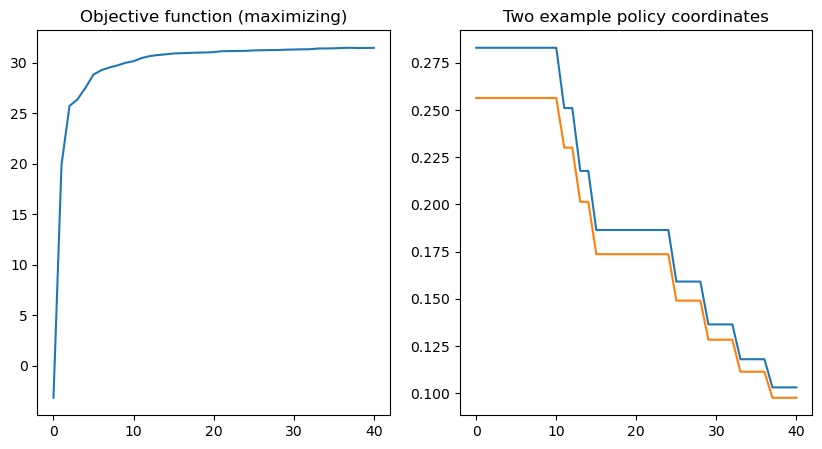

In [119]:
HORIZON = 10
BATCH = 10

def StochPolicyGradient(mdp,eta=20, nb_steps = 40):
    def logger(theta):
        return {
            'pi': softmax_pi(theta),
            'J': J_unregularized(mdp, theta)
        }
    theta = jax.random.uniform(key,(mdp.n,mdp.m))
    log = [logger(theta)]
    for step in tqdm(range(nb_steps)):
        batch = sample_batch(pi,gridMDP,smp,HORIZON,BATCH)
        _g = gpomdp(batch,theta,BATCH-1,HORIZON,gridMDP.gamma)
        theta += eta * _g
        log += [logger(theta)]
    return log, theta
log, theta = StochPolicyGradient(gridMDP,eta=1e-1,nb_steps=40)

pis=jnp.stack([e['pi'] for e in log])
js=jnp.stack([e['J'] for e in log])
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(js)
ax[0].set_title('Objective function (maximizing)')
ax[1].plot(pis[:,0,:2])
ax[1].set_title('Two example policy coordinates')
plt.show()

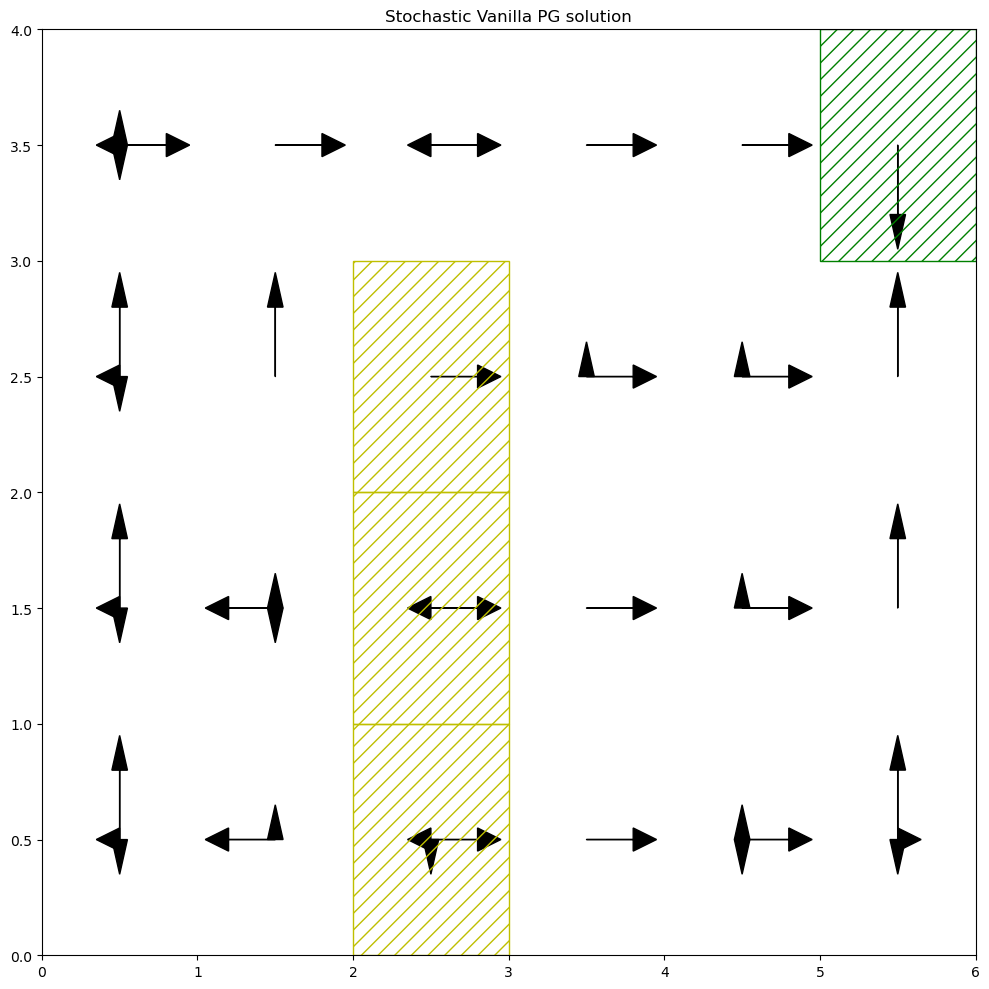

In [120]:
fig, ax = plt.subplots(1,figsize=(10,10,))
gridplot(gridMDP,ax,stochastic_policy=softmax_pi(t_v),goals=goals)
ax.set_title('Stochastic Vanilla PG solution')
fig.tight_layout()